# MiniCache

In [1]:
import torch
import time
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM

/home/sriney/miniconda3/envs/hawai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# --- Configuration ---
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2-large"
# NOTE: Reduced length for stability on 4GB VRAM.
generation_length = 512 

# Determine layers dynamically
temp_config = AutoModelForCausalLM.from_pretrained(model_name).config
merge_end = temp_config.num_hidden_layers
# gpt2-large has 36 layers (0-35). We will merge the second half (18-35).
merge_start = 18

print(f"Using device: {device}")

# --- Load Model and Tokenizer (Clean, no overhead) ---
# NOTE: On 4GB VRAM, gpt2-large is highly likely to cause an Out-Of-Memory (OOM) error, 
# even with cache sharing, due to the base model size. If it fails, try 'gpt2-medium'.
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
model.config.use_cache = True # Ensure caching is enabled

print("Setup complete.")
print(f"GPT-2 Large has {model.config.num_hidden_layers} layers.")
print(f"MiniCache will merge Layers {merge_start} to {merge_end-1}.")

# --- VRAM Monitoring Helper Function ---
def get_vram_usage():
    """Returns the current GPU memory usage in GB."""
    if device == "cuda":
        # Synchronize before checking memory for an accurate reading
        torch.cuda.synchronize() 
        return torch.cuda.memory_allocated(0) / (1024**3)
    return 0

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Using device: cuda
Setup complete.
GPT-2 Large has 36 layers.
MiniCache will merge Layers 18 to 35.


In [ ]:
def analyze_inference_baseline(model, tokenizer):
    """
    Runs a true baseline test with a full KV cache.
    """
    print("\n--- Running test for strategy: 'TRUE BASELINE' ---")
    input_ids = torch.tensor([[tokenizer.bos_token_id]], dtype=torch.long).to(device)
    past_key_values = None
    timings = []
    vram_usage = []
    
    with torch.no_grad():
        for i in range(generation_length):
            start_time = time.perf_counter()
            outputs = model(input_ids=input_ids[:, -1:], past_key_values=past_key_values)
            next_token_id = torch.argmax(outputs.logits[:, -1, :], dim=-1).unsqueeze(-1)
            input_ids = torch.cat([input_ids, next_token_id], dim=-1)
            past_key_values = outputs.past_key_values
            end_time = time.perf_counter()
            
            timings.append((end_time - start_time) * 1000)
            vram_usage.append(get_vram_usage())
            
            if (i + 1) % 100 == 0:
                print(f"Generated {i + 1}/{generation_length} tokens...")
    
    print("'TRUE BASELINE' test complete.")
    return timings, vram_usage

def analyze_inference_minicache(model, tokenizer, start_layer, end_layer):
    """
    Runs an inference test using the MiniCache strategy.
    """
    print("\n--- Running test for strategy: 'MiniCache' ---")
    
    def apply_minicache(pkv, merge_start_layer, merge_end_layer):
        """
        Merges the KV cache for a range of layers by reusing the cache
        from the start layer.
        """
        # Take the KV cache from the start of the merge range.
        # This will be our shared cache.
        shared_cache = pkv[merge_start_layer]
        
        # Create a new list from the original tuple to allow modification
        new_pkv_list = list(pkv)
        
        # For all layers in the merge range, replace their cache
        # with a reference to the shared cache.
        for i in range(merge_start_layer + 1, merge_end_layer):
            new_pkv_list[i] = shared_cache
            
        return tuple(new_pkv_list)

    input_ids = torch.tensor([[tokenizer.bos_token_id]], dtype=torch.long).to(device)
    past_key_values = None
    timings = []
    vram_usage = []

    with torch.no_grad():
        for i in range(generation_length):
            start_time = time.perf_counter()
            outputs = model(input_ids=input_ids[:, -1:], past_key_values=past_key_values)
            
            # Get the new KV cache
            pkv = outputs.past_key_values
            
            # Apply the MiniCache logic to merge layers
            if pkv is not None:
                past_key_values = apply_minicache(pkv, start_layer, end_layer)
            
            next_token_id = torch.argmax(outputs.logits[:, -1, :], dim=-1).unsqueeze(-1)
            input_ids = torch.cat([input_ids, next_token_id], dim=-1)
            end_time = time.perf_counter()

            timings.append((end_time - start_time) * 1000)
            vram_usage.append(get_vram_usage())
            
            if (i + 1) % 100 == 0:
                print(f"Generated {i + 1}/{generation_length} tokens...")
                
    print("'MiniCache' test complete.")
    return timings, vram_usage

In [ ]:
# --- Define the MiniCache Strategy ---
# gpt2-large has 36 layers (0-35). We will merge the second half.
# The cache from layer 18 will be reused for layers 19 through 35.
merge_start = 18
merge_end = model.config.num_hidden_layers

# --- Run the Two Experiments ---
baseline_timings, baseline_vram = analyze_inference_baseline(model, tokenizer)
minicache_timings, minicache_vram = analyze_inference_minicache(
    model, 
    tokenizer, 
    start_layer=merge_start, 
    end_layer=merge_end
)


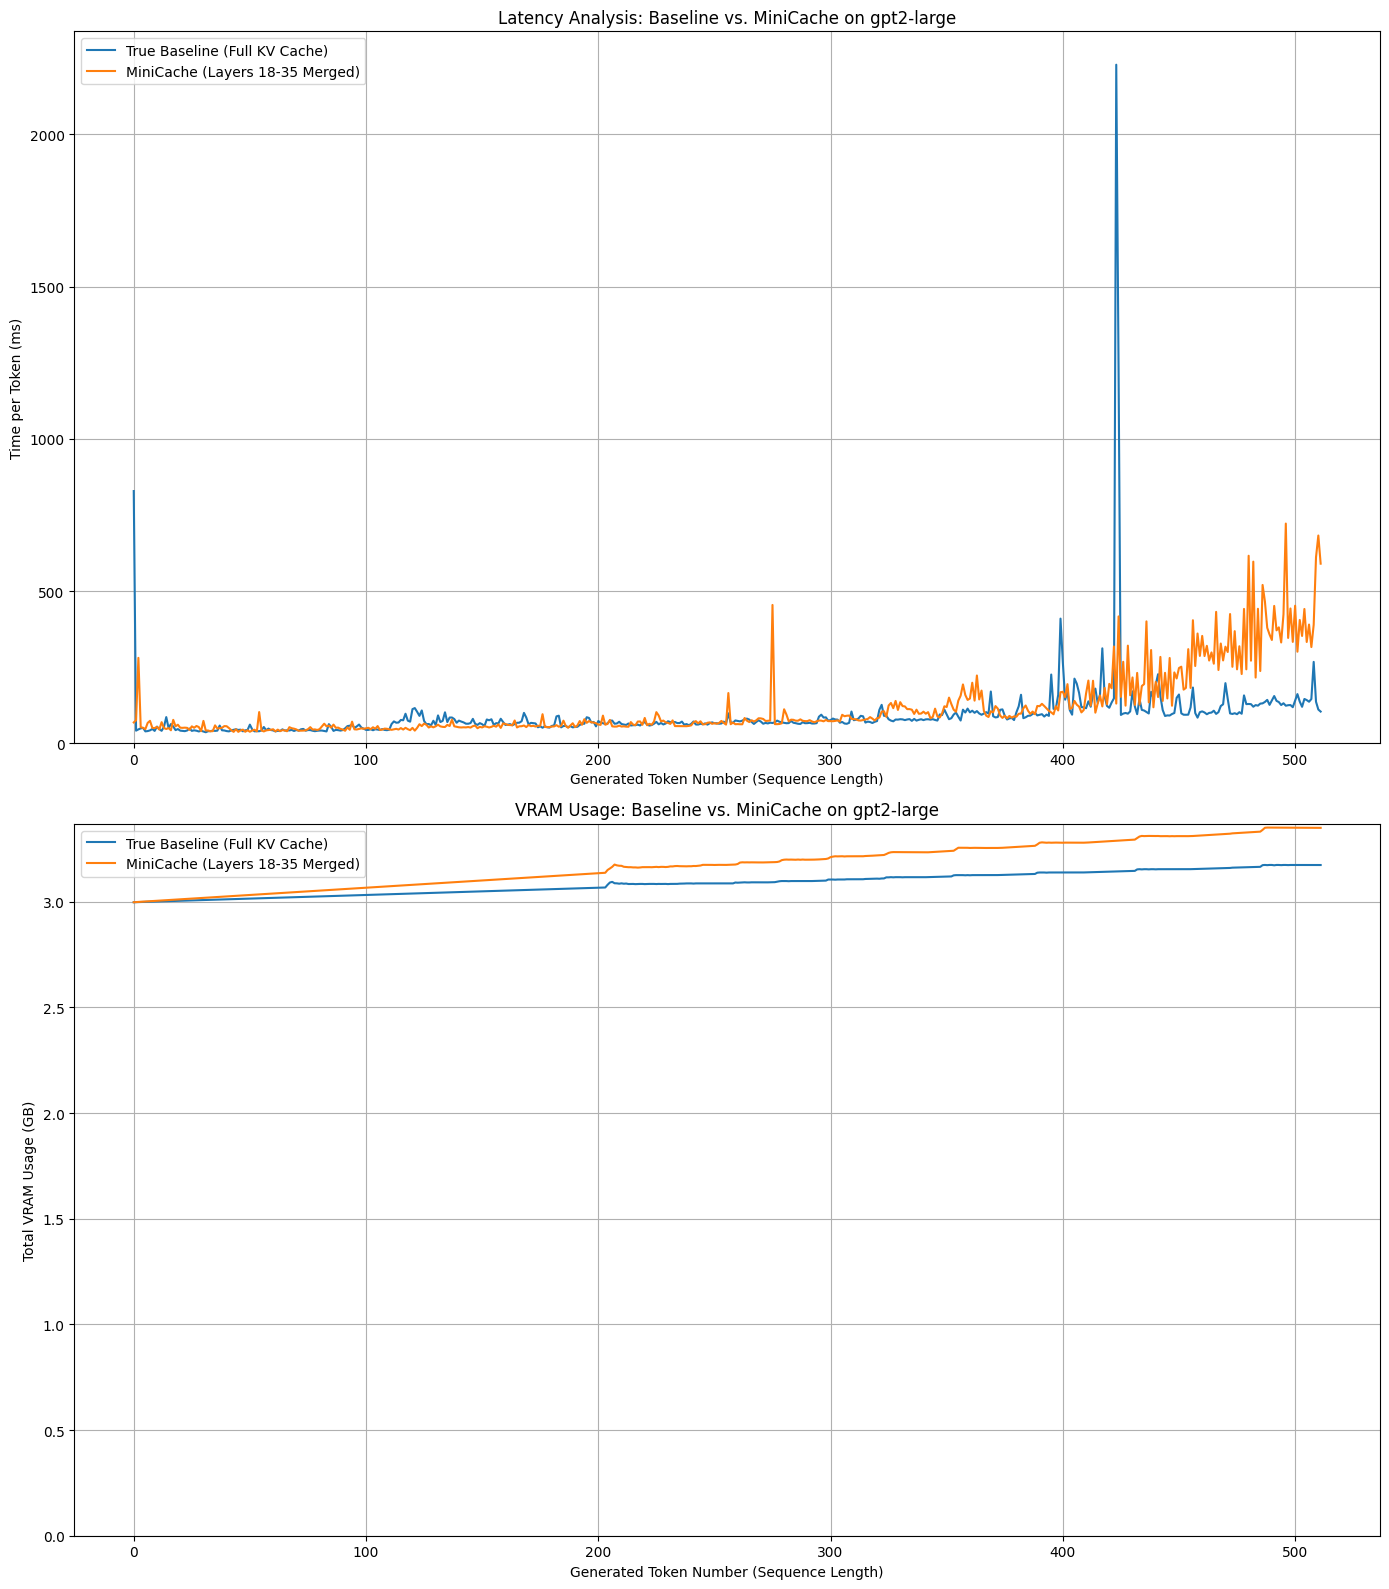

In [ ]:
# --- Create the Plots ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16))

# Plot 1: Latency (Time per Token)
ax1.plot(baseline_timings, label='True Baseline (Full KV Cache)')
ax1.plot(minicache_timings, label=f'MiniCache (Layers {merge_start}-{merge_end-1} Merged)')
ax1.set_xlabel('Generated Token Number (Sequence Length)')
ax1.set_ylabel('Time per Token (ms)')
ax1.set_title(f'Latency Analysis: Baseline vs. MiniCache on {model_name}')
ax1.legend()
ax1.grid(True)
ax1.set_ylim(bottom=0) 

# Plot 2: VRAM Usage
ax2.plot(baseline_vram, label='True Baseline (Full KV Cache)')
ax2.plot(minicache_vram, label=f'MiniCache (Layers {merge_start}-{merge_end-1} Merged)')
ax2.set_xlabel('Generated Token Number (Sequence Length)')
ax2.set_ylabel('Total VRAM Usage (GB)')
ax2.set_title(f'VRAM Usage: Baseline vs. MiniCache on {model_name}')
ax2.legend()
ax2.grid(True)
ax2.set_ylim(bottom=0)

plt.tight_layout()
plt.show()